# Using NLP to Predict Item Prices

### Contributors: Alexander Jorenby and Jiehwan Yang

## Overview

Japan’s shopping app, Mercari, wants to automatically offer pricing suggestions to sellers based on the item’s information including: category name, brand name, item condition, shipping, and item description (Mercari 1). To solve this problem, we will use natural language processing (NLP) techniques on the item descriptions and use regression algorithms to predict the item’s price.

## Data

In [ ]:
%%shell
mkdir /root/.kaggle
mv ./kaggle.json /root/.kaggle/kaggle.json
chmod 600 /root/.kaggle/kaggle.json
kaggle competitions download -c mercari-price-suggestion-challenge
7za e train.tsv.7z
7za e test.tsv.7z

 71% 24.0M/34.0M [00:00<00:00, 36.3MB/s]
100% 34.0M/34.0M [00:00<00:00, 97.2MB/s]
 90% 67.0M/74.3M [00:00<00:00, 75.0MB/s]
100% 74.3M/74.3M [00:00<00:00, 117MB/s] 
 96% 284M/294M [00:03<00:00, 143MB/s]
100% 294M/294M [00:03<00:00, 81.9MB/s]
  0% 0.00/170k [00:00<?, ?B/s]
100% 170k/170k [00:00<00:00, 93.0MB/s]
 64% 5.00M/7.77M [00:00<00:00, 40.4MB/s]
100% 7.77M/7.77M [00:00<00:00, 49.4MB/s]

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 77912192 bytes (75 MiB)

Extracting archive: train.tsv.7z
--
Path = train.tsv.7z
Type = 7z
Physical Size = 77912192
Headers Size = 122
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      3% - train.tsv                  7% - train.tsv                 10% - tr

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
mercari_df= pd.read_csv('train.tsv',sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [ ]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


A lot of Null values in brand_name and a few in item_description. Null values are handled in later part of this notebook.

### Distribution of Price

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


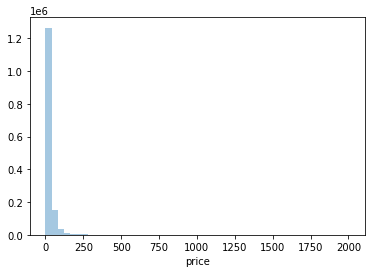

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.distplot(y_train_df,kde=False)

The target variable (price) of the original dataset is largely skewed to the right (shown in the left plot). To make it normally distributed, we transformed it by taking a log of the price (added 1 to the price before transformation in order to prevent zero or negative values).

### Distribution of Log(Price)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


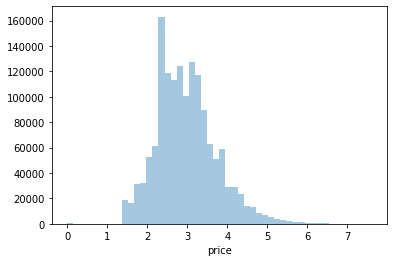

In [ ]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.distplot(y_train_df,kde=False)

Log(Price) makes it normally distributed

In [ ]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

In [ ]:
print('Shipping:\n',mercari_df['shipping'].value_counts())
print('item_condition_id:\n',mercari_df['item_condition_id'].value_counts())

Shipping:
 0    819435
1    663100
Name: shipping, dtype: int64
item_condition_id:
 1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


In [ ]:
boolean_cond= mercari_df['item_description']=='No description yet'
mercari_df[boolean_cond]['item_description'].count()

82489

# EDA

#### Distribution of Shipping variable

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.09 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.09 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


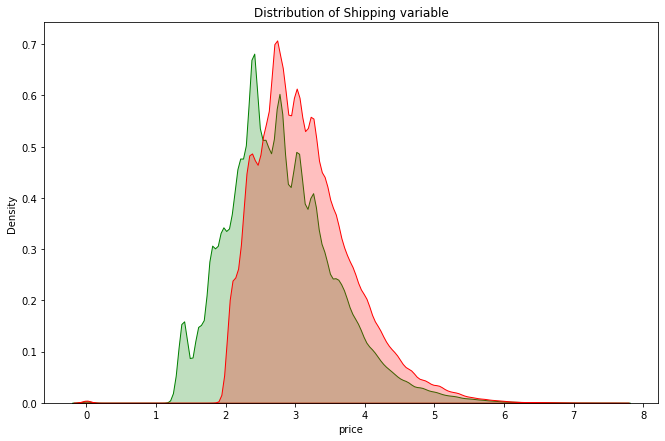

In [ ]:
plt.figure(figsize=(11,7))

# shipping paid by seller
sns.kdeplot(mercari_df[mercari_df['shipping'] == 1].loc[:, 'price'], shade=True, color="g", bw=.09, label="Seller")

# shipping paid by buyer
sns.kdeplot(mercari_df[mercari_df['shipping'] == 0].loc[:, 'price'], shade=True, color="r", bw=.09, label="Buyer")
plt.title("Distribution of Shipping variable")
plt.show()

Based on the price distributions of items, we observed a difference in the price of items depending on who paid for the shipping cost. For example, as shown in the red distribution plot, if the seller had to pay for shipping, buyers were charged more for the item. On the other hand, if the buyers had to pay for shipping, the price of an item was relatively cheaper.

## Shipping and Price Interaction

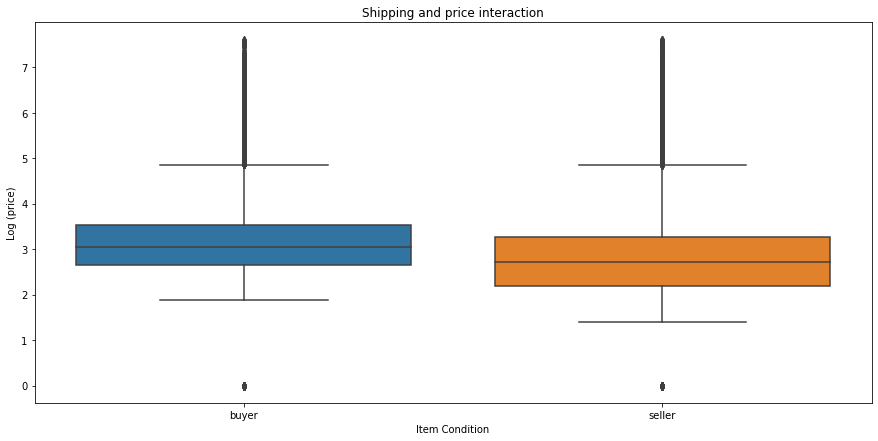

In [ ]:
plt.figure(figsize=(15,7))
ax = sns.boxplot(x='shipping', y='price', data=mercari_df)
ax.set_xticklabels(["buyer", "seller"])
plt.ylabel("Log (price)")
plt.xlabel("Shipping")

plt.title("Shipping and price interaction")
plt.show()

### Since the category name is split by '/', we create new coulmns

In [ ]:
'test1/test2/test3'.split('/')

['test1', 'test2', 'test3']

In [ ]:
# Create split_cat() function that returns cateogires (dae, jung, so) called by "apply lambda"
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Other_Null' , 'Other_Null' , 'Other_Null']

# Calls split_cat() function above and create cat_dae, cat_jung, cat_so columns in mercari_df
mercari_df['category_list'] = mercari_df['category_name'].apply(lambda x : split_cat(x))
mercari_df['category_list'].head()

0                                [Men, Tops, T-shirts]
1    [Electronics, Computers & Tablets, Components ...
2                      [Women, Tops & Blouses, Blouse]
3               [Home, Home Décor, Home Décor Accents]
4                          [Women, Jewelry, Necklaces]
Name: category_list, dtype: object

In [ ]:
mercari_df['cat_dae'] = mercari_df['category_list'].apply(lambda x:x[0])
mercari_df['cat_jung'] = mercari_df['category_list'].apply(lambda x:x[1])
mercari_df['cat_so'] = mercari_df['category_list'].apply(lambda x:x[2])

mercari_df.drop('category_list', axis=1, inplace=True)

In [ ]:
mercari_df[['cat_dae','cat_jung','cat_so']].head()

,cat_dae,cat_jung,cat_so
0,Men,Tops,T-shirts
1,Electronics,Computers & Tablets,Components & Parts
2,Women,Tops & Blouses,Blouse
3,Home,Home Décor,Home Décor Accents
4,Women,Jewelry,Necklaces


## Handling Null Values

The following attributes contained null values: item_description, brand_name, and category_name. Since they are all text data, we could not simply replace them with average or median values as we would have done with numerical variables. Moreover,  deleting records with missing variables would likely hurt our overall accuracy. Therefore, we replaced missing values with “Other_Null” for category_name and brand_name. For item_description, we replaced missing values with an empty string. The only redundant/irrelevant attribute we are given is the train_id, but since it contains values necessary to properly identify items, we did not remove them. 

In [ ]:
# Handling Null Values
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

# Check Null values now. All columns should have 0 Null values now.
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

In [ ]:
mercari_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1482535 non-null  object 
 4   brand_name         1482535 non-null  object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482535 non-null  object 
 8   cat_dae            1482535 non-null  object 
 9   cat_jung           1482535 non-null  object 
 10  cat_so             1482535 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 124.4+ MB


### Feature Encoding & Feature Vectorization

**brand name & type**

In [ ]:
print('# of unique values in brand name  :', mercari_df['brand_name'].nunique())
print('5 samples from brand name: \n', mercari_df['brand_name'].value_counts()[:5])

# of unique values in brand name  : 4810
5 samples from brand name: 
 Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64


In [ ]:
print('# of unique values in name:', mercari_df['name'].nunique())
print('7 samples in name: \n', mercari_df['name'][:7])

# of unique values in name: 1225273
7 samples in name: 
 0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
5       Bundled items requested for Ruie
6     Acacia pacific tides santorini top
Name: name, dtype: object


**Average length of item_description**

In [ ]:
pd.set_option('max_colwidth', 200)

# Average length of item_description
print('Average length of item_description:',mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

Average length of item_description: 145.7113889385411


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

In [ ]:
import gc
gc.collect()

0

## Text Processing (TF-IDF)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Convert "name" with feature vectorization
cnt_vec = CountVectorizer(max_features=30000)
X_name = cnt_vec.fit_transform(mercari_df.name)

# Convert "item_description" with feature vectorization
tfidf_descp = TfidfVectorizer(max_features = 50000, ngram_range= (1,3) , stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:',X_name.shape)
print('item_description vectorization shape:',X_descp.shape)

name vectorization shape: (1482535, 30000)
item_description vectorization shape: (1482535, 50000)


The number of unique values of the brand_name variable is 4,810. In order to transform it into a document-matrix dataset, we tokenized, removed stop words and punctuation, and normalized/vectorized the texts. We tried both CountVectorizer and TF-IDF (Term Frequency-Inverse Document Frequency)  methods to find similarities between documents. CountVectorizor finds similarities between items by comparing the number of common words appearing in both documents, whereas TF-IDF quantifies the importance of a word in a document in relation to the rarity of the word across the collection of documents. The rarer the word is across the documents, it is considered to be a significant indicator of the particular document.
The average length of the item_description variable is 145 characters. With preprocessing, we  used similar steps as we did with the brand_name variable: tokenize, remove stop words and punctuation, and convert to a document sparse matrix using one-hot-encoding.


## Using LabelBinarizer to convert to one-hot-encoding, then store in spare matrix

In [ ]:
from sklearn.preprocessing import LabelBinarizer

# Convert each feature (brand_name, item_condition_id, shipping) to one-hot-encoded sparse matrix 
lb_brand_name= LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])

lb_shipping= LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# Convert each feature (cat_dae, cat_jung, cat_so) to one-hot-encoded spare matrix
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae= lb_cat_dae.fit_transform(mercari_df['cat_dae'])

lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])

lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [ ]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand_shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
X_brand_shape:(1482535, 4810), X_item_cond_id shape:(1482535, 5)
X_shipping shape:(1482535, 1), X_cat_dae shape:(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape:(1482535, 871)


In [ ]:
import gc
gc.collect()

669

## Merge feature-vectorized spare matrix with one-hot-encoded spare matrix by using hstack() function

In [ ]:
from  scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id,
            X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# Use hstack() to merge all the datasets that are encoded and vectorized in the previous steps.
# 사이파이 sparse 모듈의 hstack 함수를 이용하여 앞에서 인코딩과 Vectorization을 수행한 데이터 셋을 모두 결합. 
X_features_sparse= hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# Data set consumes too much memory, so we need to delete it after we are done using it.
# 데이터 셋이 메모리를 많이 차지하므로 사용 용도가 끝났으면 바로 메모리에서 삭제. 
del X_features_sparse
gc.collect()

<class 'scipy.sparse.csr.csr_matrix'> (1482535, 85812)


129

# Modeling

In [ ]:
def rmsle(y , y_pred):
    # Compute RMSLE with log1p instead of log to prevent underflow, overflow
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test , preds): 
    # We need to convert the log1p back to its original form.
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)
    
    # RMSLE
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

Just as Kaggle uses the RSMLE to evaluate the performance of models, we also decided to use the same metric to evaluate our models.

RMSLE adds one to each item you are comparing, takes the log, and then squares the difference (as you would in the normal root squared error calculation). RMSLE is preferred over other metrics because it doesn’t penalize large errors as much as the other error calculation measures. For instance, if you are close to the correct price and have low error, this equation will minimize the effects a major outlier has on the total error.

We created a model_train_predict() function to train on a number of different models.

Given user-inputted text descriptions of products, including details like product category name, brand name, item condition, and item description, we built models that automatically suggest the right product prices.

In [ ]:
import gc 
from  scipy.sparse import hstack

def model_train_predict(model,matrix_list):
    # Merge sparse matrix using hstack provided by scipy.sparse module
    X= hstack(matrix_list).tocsr()     
    
    X_train, X_test, y_train, y_test=train_test_split(X, mercari_df['price'], 
                                                      test_size=0.2, random_state=156)
    
    # Model traiing and test
    model.fit(X_train , y_train)
    preds = model.predict(X_test)
    
    del X , X_train , X_test , y_train 
    gc.collect()
    
    return preds , y_test

## Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

linear_model = Ridge(solver = "lsqr", fit_intercept=False)

# RMSLE without Item Description
sparse_matrix_list = (X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model ,matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test , linear_preds))

# RMSLE with Item Description
sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model , matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:',  evaluate_org_price(y_test ,linear_preds))

Item Description을 제외했을 때 rmsle 값: 0.5027973690574066
Item Description을 포함한 rmsle 값: 0.47114311507018


The first algorithm that we used was Ridge Regression, which reduces the weights for input variables that do not have a significant contribution to the price prediction. This not only helps build a complex model but avoids over-fitting at the same time by optimizing estimated coefficients (weights) on new datasets. We were able to observe the significance of item description variables on item price by comparing the models for two cases: with and without the item description. The RMSLE of the prediction cases were 0.47 and 0.50 respectively which support our initial hypothesis that item description is a contributing factor for predicting item price. The following models used item description as independent variables.

In [ ]:
import gc
gc.collect()

422

## LGBM

In [ ]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# RMSLE of LGBM
lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds , y_test = model_train_predict(model = lgbm_model , matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값:',  evaluate_org_price(y_test , lgbm_preds))

LightGBM rmsle 값: 0.45668225613337415


For the second algorithm, we used LightGBM (LGBM) because of its fast training speed, lower consumption of memory, support of parallel and GPU learning, and capability to handle large-scale data.  Compared to XGBoost, LGBM was capable of performing equally good with large datasets with a significant reduction in training time. Furthermore, we wanted to compare this model with Ridge Regression in order to determine which one is better suited for price prediction. Consequently, we found that the RMSLE of the model is 0.46.  

In [ ]:
# RMSLE of ensemble of LGBM and Ridge
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:',  evaluate_org_price(y_test , preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle 값: 0.45062742010765844


The third algorithm that we used was an ensemble of LGBM and Ridge Regression.  In order to boost our model’s performance, we experimented building an ensemble of both methods which resulted in an RMSLE of 0.45 – lowest RMSLE (best performance) among all models.

## Conclusion

Undoubtedly, additional improvements can be made: hyperparameter tuning, cross validation, and using alternative models. Due to the size of the dataset and limited computation power, we were not able to perform in depth hyperparameter tuning and cross validation using MLFlow. However, if we were to be given enough computation power and time to execute models, we expect to improve our model performance with additional hyperparameter tuning and cross validation. We could also utilize additional data from Mercari in order to enhance the performance of the models.  Furthermore, NLP-based (specifically transformer) models can be utilized such as the bidirectional encoder representations from transformers (BERT).  Although it can be computationally expensive, we expect the model to perform better with BERT because of its ability to process large amounts of text data. Nevertheless, our models performed relatively similar to some of the highest scoring models within the Mercari Kaggle competition.  Although they did not outperform the highest scoring models.

All in all, it was a great experience collaborating on ML project by using vairous collaborating tools: Docker and Git. As for Docker, we were surprised by its power to make collaboration easier by enabling the application to run in different environments, so that we could run each others work on our local machines without having to worry about package versions.